<a href="https://colab.research.google.com/github/flowergum/NN2/blob/main/%D0%A0%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_one_hot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
path_to_file = "drive/My Drive/Recurrent_NN/input/frankenstein.txt"

# Открыть файл на чтение в бинарном виде, считать и декодировать
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [4]:
def check_text(text):
    # Посмотрим первые 300 символов
    print(text[:300])
    # Посмотрим общее количество символов
    print ('\nLength of text: {} characters'.format(len(text)))
    # Построим перечень уникальных символов, а numpy поможет нам работать с массивом
    vocab = np.array(sorted(set(text)))
    # Выведем на экран все уникальные символы
    print ('{} unique characters:'.format(len(vocab)))
    print(vocab)
    # Нестандартные специальные символы в английском начинаются после символа 'z'
    print ('Bad characters in english text:')
    print(vocab[vocab > 'z'])
    return vocab

vocab = check_text(text)

﻿Letter 1

_To Mrs. Saville, England._


St. Petersburgh, Dec. 11th, 17—.


You will rejoice to hear that no disaster has accompanied the
commencement of an enterprise which you have regarded with such evil
forebodings.  I arrived here yesterday, and my first task is to assure
my dear sis

Length of text: 428004 characters
85 unique characters:
['\n' '\r' ' ' '!' '(' ')' ',' '-' '.' '0' '1' '2' '3' '4' '5' '6' '7' '8'
 '9' ':' ';' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N'
 'O' 'P' 'R' 'S' 'T' 'U' 'V' 'W' 'Y' '[' ']' '_' 'a' 'b' 'c' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x'
 'y' 'z' 'æ' 'è' 'é' 'ê' 'ô' '—' '‘' '’' '“' '”' '\ufeff']
Bad characters in english text:
['æ' 'è' 'é' 'ê' 'ô' '—' '‘' '’' '“' '”' '\ufeff']


In [5]:
# Удаляем символы после последнего значимого
text = text.translate({ord(c): None for c in vocab[vocab > 'z']}) # As recommended in https://stackoverflow.com/questions/3939361/remove-specific-characters-from-a-string-in-python
# Снова смотрим на текст, на словарь и пересохраняем его себе
vocab = check_text(text)

Letter 1

_To Mrs. Saville, England._


St. Petersburgh, Dec. 11th, 17.


You will rejoice to hear that no disaster has accompanied the
commencement of an enterprise which you have regarded with such evil
forebodings.  I arrived here yesterday, and my first task is to assure
my dear siste

Length of text: 426888 characters
74 unique characters:
['\n' '\r' ' ' '!' '(' ')' ',' '-' '.' '0' '1' '2' '3' '4' '5' '6' '7' '8'
 '9' ':' ';' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N'
 'O' 'P' 'R' 'S' 'T' 'U' 'V' 'W' 'Y' '[' ']' '_' 'a' 'b' 'c' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x'
 'y' 'z']
Bad characters in english text:
[]


In [6]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = vocab

text_as_int = np.array([char2idx[c] for c in text]).astype('uint8')

In [7]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'Letter 1\r\n\r\n_' ---- characters mapped to int ---- > [33 52 67 67 52 65  2 10  1  0  1  0 47]


In [8]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)
print("There will be {} examples".format(examples_per_epoch))

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
print("Let's check tensor properties: {}".format(char_dataset))

# Enumerate method
for i,v in char_dataset.enumerate().take(7):
    print (idx2char[v.numpy()])
# Simplier method
for v in char_dataset.take(7):
    print (idx2char[v.numpy()])

There will be 4226 examples
Let's check tensor properties: <TensorSliceDataset shapes: (), types: tf.uint8>
L
e
t
t
e
r
 
L
e
t
t
e
r
 


In [9]:
# Slicing dataset
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

# Now we can check the properties
print("Let's check tensor properties: {}".format(sequences))

# Visualize first 2 sequences translating them to letters
for item in sequences.take(2):
    print (idx2char[item.numpy()])

Let's check tensor properties: <BatchDataset shapes: (101,), types: tf.uint8>
['L' 'e' 't' 't' 'e' 'r' ' ' '1' '\r' '\n' '\r' '\n' '_' 'T' 'o' ' ' 'M'
 'r' 's' '.' ' ' 'S' 'a' 'v' 'i' 'l' 'l' 'e' ',' ' ' 'E' 'n' 'g' 'l' 'a'
 'n' 'd' '.' '_' '\r' '\n' '\r' '\n' '\r' '\n' 'S' 't' '.' ' ' 'P' 'e' 't'
 'e' 'r' 's' 'b' 'u' 'r' 'g' 'h' ',' ' ' 'D' 'e' 'c' '.' ' ' '1' '1' 't'
 'h' ',' ' ' '1' '7' '.' '\r' '\n' '\r' '\n' '\r' '\n' 'Y' 'o' 'u' ' ' 'w'
 'i' 'l' 'l' ' ' 'r' 'e' 'j' 'o' 'i' 'c' 'e' ' ' 't' 'o']
[' ' 'h' 'e' 'a' 'r' ' ' 't' 'h' 'a' 't' ' ' 'n' 'o' ' ' 'd' 'i' 's' 'a'
 's' 't' 'e' 'r' ' ' 'h' 'a' 's' ' ' 'a' 'c' 'c' 'o' 'm' 'p' 'a' 'n' 'i'
 'e' 'd' ' ' 't' 'h' 'e' '\r' '\n' 'c' 'o' 'm' 'm' 'e' 'n' 'c' 'e' 'm' 'e'
 'n' 't' ' ' 'o' 'f' ' ' 'a' 'n' ' ' 'e' 'n' 't' 'e' 'r' 'p' 'r' 'i' 's'
 'e' ' ' 'w' 'h' 'i' 'c' 'h' ' ' 'y' 'o' 'u' ' ' 'h' 'a' 'v' 'e' ' ' 'r'
 'e' 'g' 'a' 'r' 'd' 'e' 'd' ' ' 'w' 'i' 't']


In [10]:
def show_str(item, prefix=None):
    if prefix is not None:
       print(prefix)
    print("".join(idx2char[item]))

# Visualize first 3 sequences
for i,v in sequences.enumerate().take(3):
    show_str(v, "Sequence {}:".format(i))

Sequence 0:
Letter 1

_To Mrs. Saville, England._


St. Petersburgh, Dec. 11th, 17.


You will rejoice to
Sequence 1:
 hear that no disaster has accompanied the
commencement of an enterprise which you have regarded wit
Sequence 2:
h such evil
forebodings.  I arrived here yesterday, and my first task is to assure
my dear sister o


In [11]:
# Define splitting method
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

# Test splitting method
print(split_input_target("Test phrase"))

# Creating dataset from sequences with our splitting method
dataset = sequences.map(split_input_target)

('Test phras', 'est phrase')


In [12]:
for input_example, target_example in dataset.take(2):
    show_str (input_example, 'Input data: ')
    show_str (target_example, 'Target data: ')

Input data: 
Letter 1

_To Mrs. Saville, England._


St. Petersburgh, Dec. 11th, 17.


You will rejoice t
Target data: 
etter 1

_To Mrs. Saville, England._


St. Petersburgh, Dec. 11th, 17.


You will rejoice to
Input data: 
 hear that no disaster has accompanied the
commencement of an enterprise which you have regarded wi
Target data: 
hear that no disaster has accompanied the
commencement of an enterprise which you have regarded wit


In [13]:
# Take first dataset string pair again
for input_example, target_example in dataset.take(1):
    pass
# Show symbols for each time step as illustration
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, idx2char[input_idx]))
    print("  expected output: {} ({:s})".format(target_idx, idx2char[target_idx]))

Step    0
  input: 33 (L)
  expected output: 52 (e)
Step    1
  input: 52 (e)
  expected output: 67 (t)
Step    2
  input: 67 (t)
  expected output: 67 (t)
Step    3
  input: 67 (t)
  expected output: 52 (e)
Step    4
  input: 52 (e)
  expected output: 65 (r)


In [14]:
# Check dataset classes
print("dataset class is {}".format(dataset))
print("dataset is a child of tf.data.Dataset? {}.".format(isinstance(dataset, tf.data.Dataset)))

# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset_batched = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print("dataset_batched is new variable of class {}.".format(dataset_batched))
print("dataset_batched is a child of tf.data.Dataset? {}.".format(isinstance(dataset_batched, tf.data.Dataset)))

dataset class is <MapDataset shapes: ((100,), (100,)), types: (tf.uint8, tf.uint8)>
dataset is a child of tf.data.Dataset? True.
dataset_batched is new variable of class <BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.uint8, tf.uint8)>.
dataset_batched is a child of tf.data.Dataset? True.


In [15]:
# Take first dataset batch as a pair
for input_batch, target_batch in dataset_batched.take(1):
    pass

# You can check that we have 2D array with the following debug output
print("input_batch is new variable of class {}.".format(input_batch))
print("So dataset_batched can be converted to a pair of arrays with shape {} and {}.".format(input_batch.shape, target_batch.shape))

# Let's look into some strings
for i in range(2):
    input_example = input_batch[i]
    target_example = target_batch[i]
    print("String pair #{}".format(i))
    show_str(input_example, "Input sequence:")
    show_str(target_example, "Target sequence:")

input_batch is new variable of class [[55  6  2 ... 68 60 52]
 [72  2 62 ... 55  2 30]
 [67 55 52 ... 53 59 68]
 ...
 [ 2 37 48 ... 67 61 56]
 [65 52 63 ... 55 52  2]
 [52 65 52 ... 58  2 62]].
So dataset_batched can be converted to a pair of arrays with shape (64, 100) and (64, 100).
String pair #0
Input sequence:
h, cried she, that I were to die with you; I
cannot live in this world of misery.

Justine assume
Target sequence:
, cried she, that I were to die with you; I
cannot live in this world of misery.

Justine assumed
String pair #1
Input sequence:
y of the seas rather than abandon my
purpose. I hoped to induce you to grant me a boat with which I
Target sequence:
 of the seas rather than abandon my
purpose. I hoped to induce you to grant me a boat with which I 


In [16]:
for input_batch, target_batch in dataset_batched.take(1):
    pass
tf.one_hot(input_batch, len(vocab))

<tf.Tensor: shape=(64, 100, 74), dtype=float32, numpy=
array([[[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0.,

In [17]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# Number of RNN units
lstm_units = 1024

def build_model(vocab_size, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # To call tf.one_hot() we use Lambda, but we also have to cast type to uint8 
    # because otherwise model weights can't be imported as they do not support default float32 type.
    # We also have to define batch shape because model can't be used wighout knowing its input shape.
    # It can be defined on first use, but it is more simple to define it now.
    tf.keras.layers.Lambda(lambda x: tf.one_hot(tf.cast(x, 'uint8'), vocab_size), 
                           batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
  return model

In [18]:
model_batched = build_model(
  vocab_size = len(vocab),
  rnn_units=lstm_units,
  batch_size=BATCH_SIZE)

model_batched.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (64, None, 74)            0         
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          4501504   
_________________________________________________________________
dense (Dense)                (64, None, 74)            75850     
Total params: 4,577,354
Trainable params: 4,577,354
Non-trainable params: 0
_________________________________________________________________


In [19]:
for input_example_batch, target_example_batch in dataset_batched.take(1):
  print("Input shape ", input_example_batch.shape, "# (batch_size, sequence_length)")
  print("Target shape ", target_example_batch.shape, "# (batch_size, sequence_length)")
  example_batch_predictions = model_batched(input_example_batch)
  print("Prediction shape ", example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape  (64, 100) # (batch_size, sequence_length)
Target shape  (64, 100) # (batch_size, sequence_length)
Prediction shape  (64, 100, 74) # (batch_size, sequence_length, vocab_size)


In [20]:
sampled_indices = tf.argmax(example_batch_predictions[0], axis=1)
print(sampled_indices)

tf.Tensor(
[18 21 40 68 73 73 73 73 73 71 71 71 71 65 65 65 65 65 21 71 71 71 71 42
 64  4  4  4  4  4  4  3 27 15 62 15 22 48 48 48 48 22 48 71  4 48 40 71
 71  4 48 22 22 15  4 68 22 68 68 71 71 71 10 10 71 16 16 16 72 72 65  6
 72 70 48 66 48 48 48 48 48 48 48 48 48 48 48 48 48  3 48 48 71 42 22  4
  4  4 42 42], shape=(100,), dtype=int64)


In [21]:
show_str(input_example_batch[0], "Input sequence:")
show_str(target_example_batch[0], "Target sequence:")
show_str(sampled_indices, "Predicted sequence:")

Input sequence:
ch perpetually increased, I
brought my work near to a conclusion.

The summer months passed while
Target sequence:
h perpetually increased, I
brought my work near to a conclusion.

The summer months passed while 
Predicted sequence:
9?Tuzzzzzxxxxrrrrr?xxxxVq((((((!F6o6AaaaaAax(aTxx(aAA6(uAuuxxx11x777yyr,ywasaaaaaaaaaaaaa!aaxVA(((VV


In [22]:
model_batched.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy)

In [23]:
example_batch_loss  = tf.keras.losses.sparse_categorical_crossentropy(target_example_batch, example_batch_predictions)
print("scalar_loss: ", example_batch_loss.numpy().mean())

scalar_loss:  4.304465


In [24]:
EPOCHS=10

In [25]:
history = model_batched.fit(dataset_batched, epochs=EPOCHS)

Epoch 1/10
66/66 [==============================] - 382s 6s/step - loss: 3.1083
Epoch 2/10
66/66 [==============================] - 377s 6s/step - loss: 2.7136
Epoch 3/10
66/66 [==============================] - 382s 6s/step - loss: 2.3484
Epoch 4/10
66/66 [==============================] - 378s 6s/step - loss: 2.1871
Epoch 5/10
66/66 [==============================] - 377s 6s/step - loss: 2.0898
Epoch 6/10
66/66 [==============================] - 379s 6s/step - loss: 1.9932
Epoch 7/10
66/66 [==============================] - 378s 6s/step - loss: 1.9112
Epoch 8/10
66/66 [==============================] - 377s 6s/step - loss: 1.8327
Epoch 9/10
66/66 [==============================] - 379s 6s/step - loss: 1.7619
Epoch 10/10
66/66 [==============================] - 383s 6s/step - loss: 1.6916


In [26]:
model_weights = model_batched.get_weights()

model_single = build_model(vocab_size, lstm_units, batch_size=1)

model_single.set_weights(model_weights)

model_single.build()

In [27]:
model_single.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (1, None, 74)             0         
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           4501504   
_________________________________________________________________
dense_1 (Dense)              (1, None, 74)             75850     
Total params: 4,577,354
Trainable params: 4,577,354
Non-trainable params: 0
_________________________________________________________________


In [34]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = np.array([char2idx[s] for s in start_string])
  print("input_eval original shape is ", input_eval.shape)
  input_eval = tf.expand_dims(input_eval, 0)
  print("input_eval shape changed to ", input_eval.shape)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  # We reset the memory of RNN so it will forget the previous timeline os characters sequence
  model.reset_states()
    
  for i in range(num_generate):
      predictions = model(input_eval)
      # print("Predictions shape before squeezing ", predictions.shape)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      # print("Predictions shape after squeezing ", predictions.shape)

      # using argmax() to determine next symbol
      #predicted_id = tf.argmax(predictions[0])
      temperature = 0.021
      predicted_id = tf.random.categorical(predictions / temperature, num_samples=1)[-1,0].numpy()
      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [35]:
print(generate_text(model_single, start_string=u"We are on the verge of "))

input_eval original shape is  (23,)
input_eval shape changed to  (1, 23)
We are on the verge of the sure of the reather of the and and the some of the nother of the hares of the ine of the some of the was and the some of the reather of the soon of the hares of the count of the some that I had destroyed the soon of the count of the forth of the was and and and the forth of the more of the (are of the some of the and and and the )ore of the 6reat of the reather of the and and and the some to my eres.  I sad to the dear would not the some of the [ore of the dear bean sould and the some of the ore of the some of the count of the more of the dear some the xire of the reather of the quisted of the forth of the hares of the count of the dear to and and the soon of the companion of the tore of the reather of the sure of the are of the Rome of the forth of the reather of the forth of the some of the [ore of the the look of the tore of the reather of the companion of the count of the some that I

Эксперимент 1


In [30]:
num_of_samples = 200
probabilities = np.array([[0.5, 0.2, 0.2, 0.1]])
temperature = 1

samples = tf.random.categorical(tf.math.log(probabilities) / temperature, num_of_samples)
print(samples)

tf.Tensor(
[[0 2 0 1 0 0 0 0 0 2 0 0 0 0 2 1 2 3 3 0 0 0 2 3 0 2 2 1 0 0 0 2 2 0 0 1
  0 0 2 2 3 0 0 2 2 0 0 0 3 3 1 3 1 0 0 2 0 0 2 0 1 3 0 2 1 3 2 0 2 2 1 0
  0 0 0 0 0 2 0 0 0 0 2 2 0 1 2 0 2 1 3 2 2 0 0 2 0 0 0 2 0 3 0 2 0 0 0 0
  3 2 0 2 2 1 0 1 0 0 0 2 3 0 0 0 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 0 0 2
  0 0 0 1 3 2 1 0 1 0 0 3 2 0 0 0 1 0 1 0 3 3 1 2 0 1 0 0 1 2 0 1 2 0 1 2
  3 3 1 2 0 0 0 0 0 0 1 1 2 0 3 0 3 2 0 0]], shape=(1, 200), dtype=int64)


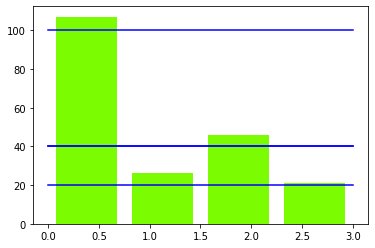

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

# the histogram of the data
_, bins, _ = plt.hist(samples, bins=len(probabilities[0]), 
                            density=False, color='lawngreen', rwidth = 0.8)
# Probability lines
for p in probabilities[0]:
    plt.plot(bins, [p*num_of_samples for _ in bins], color='b' )
plt.show()